## Alignment of activity patterns with different baselines

fMRI activity cannot be measures in absolute terms, but always relative to some (possibly implicit) baseline. Different MultiTasBattery datasets have different task / conditions in common. Given this, how do we best integrate knowledge across different datasets? 

Does it matter what baseline is chosen across datasets / runs? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

## General framework
Let us assume that the true activity during a 30s task phase of a specific task $i$ is $u_{i}$. Across fMRI measurement of a single run, we can measure the relative activity $y_{n}$. 

$ y_{n} = Z u_{i} + Z \epsilon_{i} $

where $\epsilon_{n}$ is the measurement noise.

When expressing it against a single condition (i.e. rest):
$$
Z = \begin{bmatrix}
1 & 0 & 0 & -1\\
0 & 1 & 0 & -1\\
0 & 0 & 1 & -1\\
0 & 0 & 0 & 0 
\end{bmatrix}
$$ 


When expressing these against the mean: 
$$
Z = \begin{bmatrix}
\frac{3}{4} & -\frac{1}{4} & -\frac{1}{4} & -\frac{1}{4}\\
-\frac{1}{4} & \frac{3}{4} & -\frac{1}{4} & -\frac{1}{4}\\
-\frac{1}{4} & -\frac{1}{4} & \frac{3}{4} & -\frac{1}{4}\\
-\frac{1}{4} & -\frac{1}{4} & -\frac{1}{4} & \frac{3}{4} 
\end{bmatrix}
$$ 

The information contained in these data are the same, just the values (and noise-covariances) are different. 

Now if we have multiple datasets, each with their specific (partly overlapping task sets), we can a more complex setting such as this one here: 

In [2]:
# Here two functions that make the design matrix (Z) and the predicted covariance matrix (V) for a given set of task set:
def make_zero_matrix(task_sets):
    """ design matrix with encoding against rest (condition 0)"""
    num_tasks = max([max (l) for l in task_sets])+1
    length = [len(l) for l in task_sets]
    Z = np.zeros((sum(length),num_tasks))
    V = []
    offset = 0
    for l in task_sets:
        indx = np.arange(len(l))+offset
        Z[indx,0]=-1
        Z[indx,np.array(l)] += 1
        V.append(Z[indx,:]@Z[indx,:].T)
        offset += len(l)
    V=block_diag(*V)
    return Z,V


def make_mean_matrix(task_sets):
    """ Design matrix with encoding against mean of task set"""
    num_tasks = max([max (l) for l in task_sets])+1
    length = [len(l) for l in task_sets]
    Z = np.zeros((sum(length),num_tasks))
    offset = 0
    V=[]
    for l in task_sets:
        indx = np.arange(len(l))+offset
        Z[min(indx):max(indx)+1,np.array(l)]=-1/len(l)
        Z[indx,np.array(l)] += 1
        V.append(Z[indx,:]@Z[indx,:].T)
        offset += len(l)
    V=block_diag(*V)
    return Z,V



Text(0.5, 1.0, 'Encoding vs. mean')

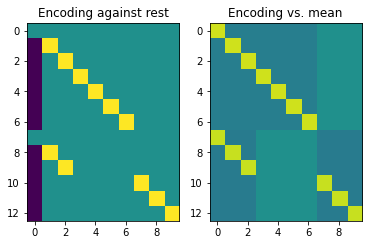

In [7]:
# Say we have 10 theoretical possible task
task_sets=[[0,1,2,3,4,5,6],[0,1,2,7,8,9]]
# For the enconding against rest as a contrast, we have the 13x10 design matrix

Z0,V0=make_zero_matrix(task_sets)
Z1,V1=make_mean_matrix(task_sets)

# The "design" matrices look like this:
plt.subplot(1,2,1)
plt.imshow(Z0,vmin=-1,vmax=1)
plt.title('Encoding against rest')
plt.subplot(1,2,2)
plt.imshow(Z1,vmin=-1,vmax=1)
plt.title('Encoding vs. mean')


Text(0.5, 1.0, 'Encoding vs. mean')

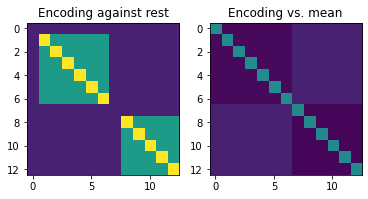

In [10]:
# What is the predicted variance of these two different ways of encoding the measurements? ?
plt.subplot(1,2,1)
plt.imshow(V0,vmin=-0.2,vmax=2)
plt.title('Encoding against rest')
plt.subplot(1,2,2)
plt.imshow(V1,vmin=-0.2,vmax=2)
plt.title('Encoding vs. mean')

In [4]:
# Given some measurements y0 and y1, we can now come up with the best estimate of the underlying task activity pattern - relative to the mean of all 10 task
P1 = np.linalg.pinv(Z1)
P0 = np.linalg.pinv(Z0)

# U1_hat = P1@y1
# U0_hat = P0@y0




Text(0.5, 1.0, 'vs mean trace 8.800')

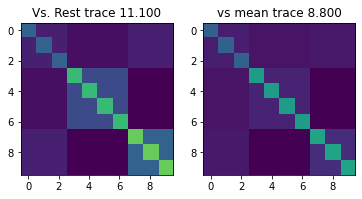

In [11]:
# Now we can compare the predicted variance of the final estimates
H = np.eye(10)-np.ones((10,10))/10
varU0 = H@P0@V0@P0.T@H.T
varU1 = H@P1@V1@P1.T@H.T

plt.subplot(1,2,1)
plt.imshow(varU0,vmin=-0.2,vmax=2)
plt.title(f'Vs. Rest trace {np.trace(varU0):.3f}')
plt.subplot(1,2,2)
plt.imshow(varU1,vmin=-0.2,vmax=2)
plt.title(f'vs mean trace {np.trace(varU1):.3f}')


As we can see, the variance of the tasks that are common, are identical under the two regimes 
It's the task that we are aliging that have lower variance if we align to the mean of all the common tasks, rather than just rest. 